### Extract binomial probabilities characterizing a compound Poisson process

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.stats import chisquare, poisson

##### We simulate a Poisson process where each entry is affected by a random "jump". The jump is a binomial process and either doubles the Poisson entry, or multiplies it by 1. This scenario describes a measurement that we are currently conducting in the lab, thus I label the random variables by what they represent in the experiment.

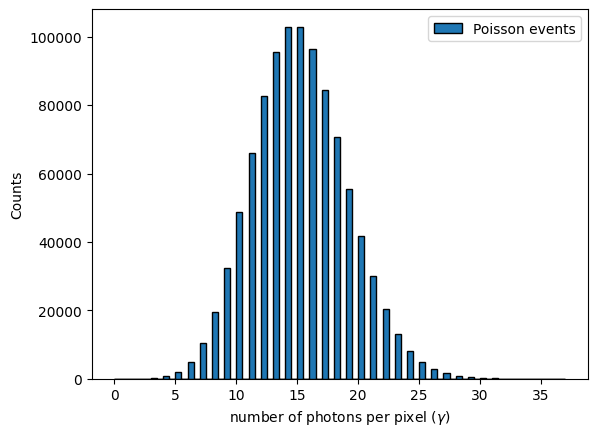

In [65]:
# start by simulating poisson distributed events with rate lambda
lambda_ = 15 #lambda is a python keyword
n = 1000000
poisson_entries = np.random.poisson(lambda_, n)

# plot the histogram
plt.hist(poisson_entries, bins=2*(max(poisson_entries)-min(poisson_entries)), density=False, histtype='stepfilled', label='Poisson events', edgecolor='black')
plt.xlabel(r'number of photons per pixel ($\gamma$)')
plt.ylabel('Counts')
plt.legend()
plt.show()

Cumulative number of photon events: 14996594


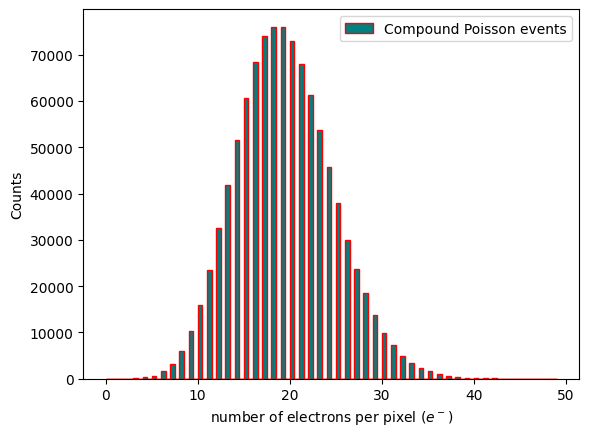

In [66]:
# now simulate n binomial outcomes with parameters n_poisson_entry and binom_p (each photon will produce either 1 or 2 electrons, we ignore the 0 case)

n_processes = np.sum(poisson_entries)
print(f"Cumulative number of photon events: {n_processes}")

# generate that many Binomial outcomes
np.random.seed(int(time.time()))
binom_p = 0.7193 # probability of producing 1 electron 
binomial = np.random.binomial(1, binom_p, n_processes)

compound_poisson_entries = []

# for each entry in the Poisson array
for entry in poisson_entries:
    # generate the corresponding number of Binomial outcomes
    binomial_entries = binomial[:entry]
    binomial = binomial[entry:]
    # for each Binomial outcome
    total_electron_per_entry = 0
    for outcome in binomial_entries:
        # add 2 to the list if the outcome is 0
        if outcome == 0:
            total_electron_per_entry += 2
        # add 1 to the list if the outcome is 1
        else:
            total_electron_per_entry += 1
    compound_poisson_entries.append(total_electron_per_entry)

compound_poisson_entries = np.array(compound_poisson_entries)

# plot the histogram
plt.hist(compound_poisson_entries, bins=2*(max(compound_poisson_entries)-min(compound_poisson_entries)), density=False, histtype='stepfilled', color='teal', label='Compound Poisson events', edgecolor='red')
plt.xlabel(r'number of electrons per pixel ($e^-$)')
plt.ylabel('Counts')
plt.legend()
plt.show()


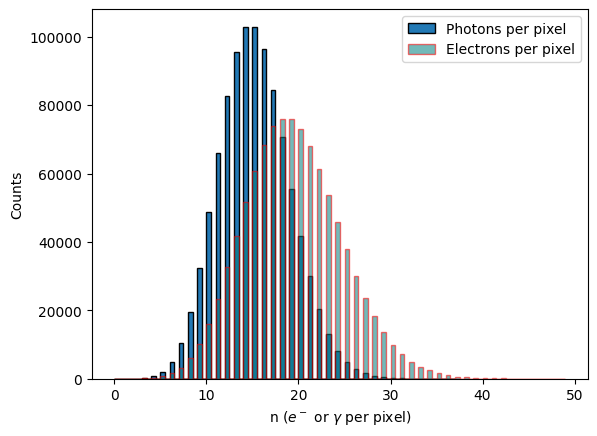

In [67]:
# superpose the two histograms
plt.hist(poisson_entries, bins=2*(max(poisson_entries)-min(poisson_entries)), density=False, histtype='stepfilled', alpha=0.99, label='Photons per pixel', edgecolor='black')
plt.hist(compound_poisson_entries, bins=2*(max(compound_poisson_entries)-min(compound_poisson_entries)), density=False, histtype='stepfilled', alpha=0.55, color='teal', label='Electrons per pixel', edgecolor='red')
plt.xlabel(r'n ($e^-$ or $\gamma$ per pixel)')
plt.ylabel('Counts')
plt.legend()
plt.show()

In [68]:
# calculate the observed frequency of each value in the compound Poisson data
unique, counts = np.unique(compound_poisson_entries, return_counts=True)
observed_freq = dict(zip(unique, counts))

# calculate the expected frequency of each value in the Poisson data
mu = np.mean(compound_poisson_entries)
var = np.var(compound_poisson_entries)
expected_freq = {x: poisson.pmf(x, mu) * len(compound_poisson_entries) for x in unique}

# ensure the sum of the expected frequencies is equal to the sum of the observed frequencies
total_observed = sum(observed_freq.values())
total_expected = sum(expected_freq.values())
scaling_factor = total_observed / total_expected
expected_freq = {x: freq * scaling_factor for x, freq in expected_freq.items()}

# perform the chi-squared test
chi2_stat, p_value = chisquare(list(observed_freq.values()), list(expected_freq.values()))

print(f"Chi-squared statistic: {chi2_stat}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("The compound distribution is not Poisson (as expected for a compound Poisson process).")
else:
    print("The compound distribution cannot be distinguished from Poisson.")

Chi-squared statistic: 112611.50637630094
P-value: 0.0
The compound distribution is not Poisson (as expected for a compound Poisson process).


We can extract the binomial probabilities by using the following formula (see e.g. https://en.wikipedia.org/wiki/Compound_Poisson_process):

$ E(C(t)) = \lambda t \cdot E(B)$ 

$ var(C(t)) = \lambda t \cdot E(B^2)$ 

where $C(t)$ is the compound poisson process and $B$ is the binomial process. This leads to:

$ \frac{E(C(t))}{var(C(t))}=\frac{1\cdot p + 2 \cdot (1-p)}{1^2\cdot p + 2^2 \cdot (1-p)} $.

We can then solve for the value of p.

In [69]:
from sympy import symbols, Eq, solve

p = symbols('p')
equation = Eq((1*p + 2*(1-p)) / (1**2*p + 2**2*(1-p)), mu/var)
solution = solve(equation, p)

print('The expected binomial probability is: ', solution[0])
print('which has relative difference: ' + str( round( 100 * (solution[0] - binom_p)/binom_p , 3) ) + '% from the true value of binom_p')

The expected binomial probability is:  0.721714087484590
which has relative difference: 0.336% from the true value of binom_p
